# Neural machine translation with attention

Refrences:
* https://arxiv.org/abs/1508.04025v5
* https://www.tensorflow.org/text/tutorials/nmt_with_attention

## Setup

In [1]:
# Using eniops package: flexible and powerful tensor operations for readable and reliable code.
# https://pypi.org/project/einops/
!pip install einops
!pip install tensorflow_text

  Obtaining dependency information for einops from https://files.pythonhosted.org/packages/29/0b/2d1c0ebfd092e25935b86509a9a817159212d82aa43d7fb07eca4eeff2c2/einops-0.7.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 2.7 MB/s eta 0:00:00


#### Import necessary libraries

In [3]:
import numpy as np
import typing
from typing import Any, Tuple
import einops
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import tensorflow as tf
import tensorflow_text as tf_text
from tensorflow.keras.callbacks import ReduceLROnPlateau
import string
import re
import random
import pickle

This class is used to check shapes throughout.


In [4]:
#@title
class ShapeChecker():
    def __init__(self):
        # Keep a cache of every axis-name seen
        self.shapes = {}
    
    def __call__(self, tensor, names, broadcast=False):
        if not tf.executing_eagerly():
            return

        parsed = einops.parse_shape(tensor, names)

        for name, new_dim in parsed.items():
            old_dim = self.shapes.get(name, None)

            if (broadcast and new_dim == 1):
                continue

            if old_dim is None:
                # If the axis name is new, add its length to the cache.
                self.shapes[name] = new_dim
                continue

            if new_dim != old_dim:
                raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                                                 f"        found: {new_dim}\n"
                                                 f"        expected: {old_dim}\n")

## Data

### Download and prepare the dataset

1. Add a *start* and *end* token to each sentence.
3. Create a word index and reverse word index (dictionaries mapping from word → id and id → word).
4. Pad each sentence to a maximum length.

In [11]:
import pickle
import random

# Paths to the train input and output data
train_input_path = "/kaggle/input/csce636-project2/Train_input"
train_output_path = "/kaggle/input/csce636-project2/Train_output"

# Load train input and output data using pickle
train_inputs_1 = pickle.load(open(train_input_path, 'rb'))
train_outputs_1 = pickle.load(open(train_output_path, 'rb'))

# Combine train inputs and outputs into text pairs
text_pairs = []
for lang1, lang2 in zip(train_inputs_1, train_outputs_1):
    # Combine languages into pairs
    text_pairs.append((lang1, lang2))

# Shuffle the text pairs and split into train and validation sets
random.seed(1349)
random.shuffle(text_pairs)

# Define the number of samples for validation and training sets
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - num_val_samples

# Split text pairs into train and validation sets
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples:]

# Print the number of samples in train and validation sets
print(len(train_pairs))
print(len(val_pairs))

# Separate train and validation inputs and outputs
train_inputs = [pair[0] for pair in train_pairs]
train_outputs = [pair[1] for pair in train_pairs]

val_inputs = [pair[0] for pair in val_pairs]
val_outputs = [pair[1] for pair in val_pairs]


95200
16800


In [13]:
print(train_inputs[1])
print(train_outputs[1])
print(val_inputs[1])
print(val_outputs[1])

a e a h a d b d b d a e b d b d 
b d b d a d d e b d a e g b d a h f h i a e j 
a f a f a g a e b d c g c e a h b d b d b d 
b d a e d c g a g e f c e a f g h b d b d b d a h j k l a f i m 


Create a `tf.data.Dataset` of strings that shuffles and batches them efficiently:

In [14]:
# Define the buffer size and batch size for the dataset
BUFFER_SIZE = len(train_inputs)
BATCH_SIZE = 64

# Create TensorFlow datasets for training and validation with selected inputs and outputs
# Shuffle the training data with the defined buffer size and create batches of defined batch size
train_raw = (
    tf.data.Dataset
    .from_tensor_slices((train_inputs, train_outputs))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))

# Create a TensorFlow dataset for validation by shuffling the validation data and batching
val_raw = (
    tf.data.Dataset
    .from_tensor_slices((val_inputs, val_outputs))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))


In [15]:
# Display the lengths of the train and validation datasets
print(len(train_raw))
print(len(val_raw))

# Iterate through the training dataset and print the first batch of context and target strings
for example_context_strings, example_target_strings in train_raw.take(1):
    # Display the first 5 context strings
    print(example_context_strings[:5])
    print()  # Empty line for separation
    # Display the first 5 target strings
    print(example_target_strings[:5])
    break  # Break the loop after printing the first batch

1488
263
tf.Tensor(
[b'a d a g b d c g a h c f b d c f '
 b'a g a e a f a d c e a f c d a h b d a e b d b d b d c g '
 b'a e a d a d b d a g a e c f b d a g c e a d c g c f '
 b'a g a g a g c g a f b d a e b d b d c g '
 b'a h a f c f b d c d a f c g a e c e '], shape=(5,), dtype=string)

tf.Tensor(
[b'b d c g a g d e c f b d c f a h g h i a d f j '
 b'c e c d b d b d a e g b d a h f h i a f e j a d d k b d a f l m a e ed c g a g ee ef '
 b'b d c f a e e b d a g f g a d d h c e c g c f a d k l a g j m a d i ed a e ee '
 b'c g b d b d a e f a f e g a g d h b d a g i j c g a g k l '
 b'c f b d a f d e c d c g c e a e i a f h j a h f g k '], shape=(5,), dtype=string)


### Text preprocessing

All the text processing happens inside the model using a `layers.TextVectorization` layer.

In [16]:
def preprocessing(text):
    # Strip whitespace: Remove leading and trailing spaces.
    text = tf.strings.strip(text)
    
    # Add start and end tokens to the text.
    text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
    
    return text

#### Source Text Vectorization

Using a `tf.keras.layers.TextVectorization` layer which will handle the vocabulary extraction and conversion of input text to sequences of tokens.

In [17]:
# Define the maximum vocabulary size for tokenizing the text
max_vocab_size = 100

# Initialize a TextVectorization layer for processing context text
context_text_processor = tf.keras.layers.TextVectorization(
    standardize=preprocessing,  # Apply a specified preprocessing function
    max_tokens=max_vocab_size,  # Limit the vocabulary size to a maximum number of tokens
    ragged=True  # Handle variable-length sequences with ragged tensors
)

The `TextVectorization` layer has an `adapt` method. This method reads one epoch of the training data, and works a lot like `Model.fit`. This `adapt` method initializes the layer based on the data. Here it determines the vocabulary:

In [18]:
# Adapt the text processor to the training dataset's context data
context_text_processor.adapt(train_raw.map(lambda context, target: context))

# Display the first 100 words from the vocabulary of the text processor
# Since the dataset is small, the vocabulary contains only 12 words
context_text_processor.get_vocabulary()[:100]

['', '[UNK]', 'a', 'd', 'b', 'c', 'f', 'g', 'e', 'h', '[START]', '[END]']

#### Target Text Vectorization

In [19]:
# Initialize a TextVectorization layer for target text with defined parameters
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=preprocessing,  # Define standardization function for text preprocessing
    max_tokens=max_vocab_size,  # Define the maximum vocabulary size
    ragged=True  # Allow ragged tensors as output
)

# Adapt the target_text_processor to the training dataset by extracting targets
target_text_processor.adapt(train_raw.map(lambda context, target: target))

# Get the vocabulary of the adapted target_text_processor (first 100 tokens)
target_text_processor.get_vocabulary()[:100]


['',
 '[UNK]',
 'd',
 'a',
 'b',
 'c',
 'f',
 'g',
 'e',
 'h',
 'j',
 'i',
 '[START]',
 '[END]',
 'k',
 'l',
 'm',
 'ed',
 'ee',
 'ef',
 'eg',
 'eh']

In [20]:
# Process the context strings to tokens using the context_text_processor
example_tokens = context_text_processor(example_context_strings)

# Display the first 3 rows of tokens and all columns
example_tokens[:3, :]


<tf.RaggedTensor [[10, 2, 3, 2, 7, 4, 3, 5, 7, 2, 9, 5, 6, 4, 3, 5, 6, 11],
 [10, 2, 7, 2, 8, 2, 6, 2, 3, 5, 8, 2, 6, 5, 3, 2, 9, 4, 3, 2, 8, 4, 3, 4,
  3, 4, 3, 5, 7, 11]                                                      ,
 [10, 2, 8, 2, 3, 2, 3, 4, 3, 2, 7, 2, 8, 5, 6, 4, 3, 2, 7, 5, 8, 2, 3, 5,
  7, 5, 6, 11]                                                            ]>

In [21]:
# Using the get_vocabulary method to convert token IDs back to text
# context_text_processor is an instance of text processor class

# Get the vocabulary (mapping of token IDs to text) from the text processor
context_vocab = np.array(context_text_processor.get_vocabulary())

# Retrieve token IDs from the example_tokens Tensor and convert them back to text using the vocabulary
tokens = context_vocab[example_tokens[0].numpy()]  # example_tokens is a Tensor
text_from_tokens = ' '.join(tokens)  # Join the tokens to reconstruct the text


Text(0.5, 1.0, 'Mask')

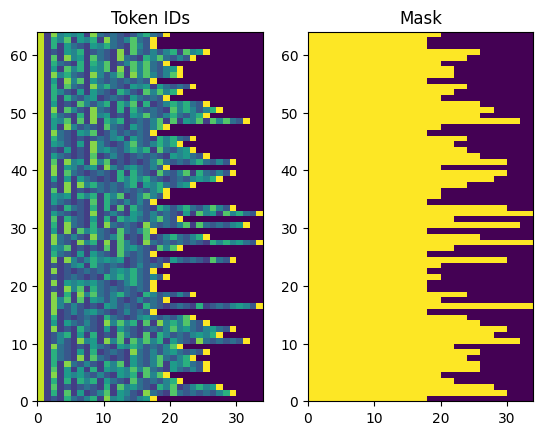

In [22]:
# returned token IDs are zero-padded. This can easily be turned into a mask:

# Display the Token IDs using pcolormesh in the first subplot
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens.to_tensor())  # Plot token IDs as a colormesh
plt.title('Token IDs')  # Set title for the subplot

# Create a Mask by checking non-zero values in the token IDs tensor and display it in the second subplot
plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens.to_tensor() != 0)  # Plot a mask where non-zero values are True
plt.title('Mask')  # Set title for the subplot


### Process the dataset



The `process_text` function below converts the `Datasets` of strings, into  0-padded tensors of token IDs. It also converts from a `(context, target)` pair to an `((context, target_in), target_out)` pair for training with `keras.Model.fit`. Keras expects `(inputs, labels)` pairs, the inputs are the `(context, target_in)` and the labels are `target_out`. The difference between `target_in` and `target_out` is that they are shifted by one step relative to eachother, so that at each location the label is the next token.

In [23]:
# Define a function to process text data
def process_text(context, target):
    # Process context text using a text processor and convert it to a tensor
    context = context_text_processor(context).to_tensor()
    
    # Process target text using a text processor
    target = target_text_processor(target)
    
    # Prepare input and output target tensors for training
    targ_in = target[:, :-1].to_tensor()  # Use all elements except the last as input
    targ_out = target[:, 1:].to_tensor()  # Use all elements except the first as output
    
    return (context, targ_in), targ_out  # Return tuple containing input and output targets

# Map the process_text function to the training dataset to process the text data
train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)

# Map the process_text function to the validation dataset to process the text data
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)


In [24]:
# Displaying the first sequence of context tokens, target input, and target output from the first batch:
for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
    # Display the first 10 tokens of the context
    print(ex_context_tok[0, :10].numpy())
    print()  # Empty line for separation
    # Display the first 10 tokens of the target input
    print(ex_tar_in[0, :10].numpy())
    # Display the first 10 tokens of the target output
    print(ex_tar_out[0, :10].numpy())


[10  2  6  2  7  2  3  2  7  5]

[12  5  7  5  2  3  7  2  8  5]
[5 7 5 2 3 7 2 8 5 7]


## The encoder/decoder

The following diagrams shows an overview of the model. The encoder is on the left, the decoder is on the right. At each time-step the decoder's output is combined with the encoder's output, to predict the next word.

<table>
<tr>
  <td>
   <img width=380 src="https://www.tensorflow.org/images/tutorials/transformer/RNN+attention.png"/>
  </td>
</tr>
<tr>
  <th colspan=1>Model</th>
<tr>
</table>


In [25]:
# Define the number of units for encoder, cross attention and decoder
UNITS = 256

### The encoder

The goal of the encoder is to process the context sequence into a sequence of vectors that are useful for the decoder as it attempts to predict the next output for each timestep. Since the context sequence is constant, there is no restriction on how information can flow in the encoder, so use a bidirectional-RNN to do the processing:

<!-- <table>
<tr>
  <td>
   <img width=500 src="https://tensorflow.org/images/tutorials/transformer/RNN-bidirectional.png"/>
  </td>
</tr>
<tr>
  <th>A bidirectional RNN</th>
<tr>
</table> -->

The encoder:

1. Takes a list of token IDs (from `context_text_processor`).
3. Looks up an embedding vector for each token (Using a `layers.Embedding`).
4. Processes the embeddings into a new sequence (Using a bidirectional `layers.GRU`).
5. Returns the processed sequence. This will be passed to the attention head.

In [26]:
# Define the Encoder class
class Encoder(tf.keras.layers.Layer):
    def __init__(self, text_processor, units, dropout_rate=0.2, recurrent_regularizer=None):
        super(Encoder, self).__init__()
        self.text_processor = text_processor
        self.vocab_size = text_processor.vocabulary_size()
        self.units = units

        # The embedding layer converts tokens to vectors
        self.embedding = tf.keras.layers.Embedding(self.vocab_size, units, mask_zero=True)

        # The RNN layer processes those vectors sequentially.
        self.rnn = tf.keras.layers.Bidirectional(
            merge_mode='sum',
            layer=tf.keras.layers.GRU(units,
                                       # Return the sequence and state
                                       return_sequences=True,
                                       recurrent_initializer='glorot_uniform',
                                       recurrent_regularizer=recurrent_regularizer,
                                       dropout=dropout_rate,
                                       recurrent_dropout=dropout_rate
                                       ))

    def call(self, x):
        shape_checker = ShapeChecker()
        shape_checker(x, 'batch s')

        # 2. The embedding layer looks up the embedding vector for each token.
        x = self.embedding(x)
        shape_checker(x, 'batch s units')

        # 3. The GRU processes the sequence of embeddings.
        x = self.rnn(x)
        shape_checker(x, 'batch s units')

        # 4. Returns the new sequence of embeddings.
        return x

    def convert_input(self, texts):
        texts = tf.convert_to_tensor(texts)
        if len(texts.shape) == 0:
            texts = tf.convert_to_tensor(texts)[tf.newaxis]
        context = self.text_processor(texts).to_tensor()
        context = self(context)
        return context


In [27]:
# Regularizer for the recurrent layer
regularizer = tf.keras.regularizers.L2(0.001)

# Encode the input sequence.
encoder = Encoder(context_text_processor, UNITS, dropout_rate=0.2 ,recurrent_regularizer=regularizer)
ex_context = encoder(ex_context_tok)

# Display the shapes of context tokens and encoder output
print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')

Context tokens, shape (batch, s): (64, 34)
Encoder output, shape (batch, s, units): (64, 34, 256)


### The attention layer

The attention layer lets the decoder access the information extracted by the encoder. It computes a vector from the entire context sequence, and adds that to the decoder's output.

The simplest way to calculate a single vector from the entire sequence would be to take the average across the sequence (`layers.GlobalAveragePooling1D`). An attention layer is similar, but calculates a **weighted** average across the context sequence. Where the weights are calculated from the combination of context and "query" vectors.
<!-- 
<table>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/images/tutorials/transformer/CrossAttention-new-full.png"/>
  </td>
</tr>
<tr>
  <th colspan=1>The attention layer</th>
<tr>
</table> -->

In [28]:
# Define the CrossAttention layer class
class CrossAttention(tf.keras.layers.Layer):
    def __init__(self, units, dropout_rate=0.1, **kwargs):
        super().__init__()

        # Multi-head attention mechanism
        self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)

        # Layer normalization for post-attention processing
        self.layernorm = tf.keras.layers.LayerNormalization()

        # Addition layer for skip connection
        self.add = tf.keras.layers.Add()

        # Dropout layer for regularization
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x, context):
        shape_checker = ShapeChecker()

        # Check input shapes
        shape_checker(x, 'batch t units')  # Query shape
        shape_checker(context, 'batch s units')  # Value shape

        # Perform multi-head attention operation
        attn_output, attn_scores = self.mha(
            query=x,
            value=context,
            return_attention_scores=True)

        # Check shapes after attention operation
        shape_checker(x, 'batch t units')  # Query shape remains the same
        shape_checker(attn_scores, 'batch heads t s')  # Attention scores shape

        # Cache the attention scores for visualization or analysis
        attn_scores = tf.reduce_mean(attn_scores, axis=1)
        shape_checker(attn_scores, 'batch t s')  # Reduced attention scores shape
        self.last_attention_weights = attn_scores

        # Apply dropout to the attention output
        x = self.dropout(attn_output)

        # Skip connection: add attention output to the input and normalize
        x = self.add([x, attn_output])
        x = self.layernorm(x)

        return x


In [29]:
# Create an instance of the CrossAttention layer
attention_layer = CrossAttention(UNITS, dropout_rate=0.2)

# Define an Embedding layer for the target text processing
embed = tf.keras.layers.Embedding(target_text_processor.vocabulary_size(), output_dim=UNITS, mask_zero=True)

# Embed the target input sequence
ex_tar_embed = embed(ex_tar_in)

# Apply the attention mechanism to the embedded target sequence and context
result = attention_layer(ex_tar_embed, ex_context)

# Print shapes of context, target, attention result, and attention weights
print(f'Context sequence, shape (batch, s, units): {ex_context.shape}')
print(f'Target sequence, shape (batch, t, units): {ex_tar_embed.shape}')
print(f'Attention result, shape (batch, t, units): {result.shape}')
print(f'Attention weights, shape (batch, t, s):    {attention_layer.last_attention_weights.shape}')


Context sequence, shape (batch, s, units): (64, 34, 256)
Target sequence, shape (batch, t, units): (64, 48, 256)
Attention result, shape (batch, t, units): (64, 48, 256)
Attention weights, shape (batch, t, s):    (64, 48, 34)


In [30]:
# The attention weights will sum to `1` over the context sequence, at each location in the target sequence.
attention_layer.last_attention_weights[0].numpy().sum(axis=-1)

array([0.99999994, 1.        , 0.99999994, 1.        , 1.        ,
       0.99999994, 0.99999994, 1.        , 1.        , 1.        ,
       0.99999994, 0.99999994, 1.        , 0.9999999 , 0.99999994,
       1.        , 1.        , 0.99999994, 0.99999994, 0.99999994,
       1.0000001 , 1.        , 1.        , 0.99999994, 0.9999999 ,
       1.        , 0.9999999 , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        ], dtype=float32)

Text(0.5, 1.0, 'Mask')

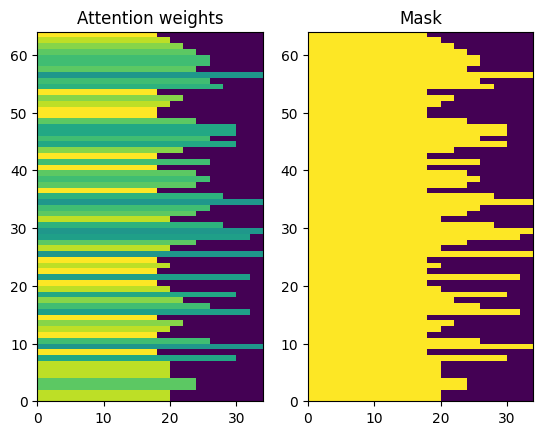

In [31]:
# Get the attention weights across the context sequences at t=0
attention_weights = attention_layer.last_attention_weights
mask = (ex_context_tok != 0).numpy()  # Creating a mask to visualize attention weights

# Plot the attention weights and mask
plt.subplot(1, 2, 1)
plt.pcolormesh(mask * attention_weights[:, 0, :])  # Visualize attention weights considering the mask
plt.title('Attention weights')  # Title for attention weights plot

plt.subplot(1, 2, 2)
plt.pcolormesh(mask)  # Display the mask
plt.title('Mask')  # Title for the mask plot

# Information about the initial attention weights due to small-random initialization
# Initially, attention weights are close to 1/(sequence_length) due to initialization
# The model will learn to make these weights less uniform as training progresses

### The decoder

The decoder's job is to generate predictions for the next token at each location in the target sequence.

1. It looks up embeddings for each token in the target sequence.
2. It uses an RNN to process the target sequence, and keep track of what it has generated so far.
3. It uses RNN output as the "query" to the attention layer, when attending to the encoder's output.
4. At each location in the output it predicts the next token.

When training, the model predicts the next word at each location. The decoder uses a unidirectional RNN to process the target sequence.

When running inference with this model it produces one word at a time, and those are fed back into the model.

<!-- <table>
<tr>
  <td>
   <img width=500 src="https://tensorflow.org/images/tutorials/transformer/RNN.png"/>
  </td>
</tr>
<tr>
  <th>A unidirectional RNN</th>
<tr>
</table> -->

In [32]:
# `Decoder` class' initializer creates all the necessary layers.
class Decoder(tf.keras.layers.Layer):
    @classmethod
    def add_method(cls, fun):
        setattr(cls, fun.__name__, fun)
        return fun

    def __init__(self, text_processor, units, dropout_rate=0.1, recurrent_regularizer=None):
        super(Decoder, self).__init__()

        # Store text processor information and vocabulary size
        self.text_processor = text_processor
        self.vocab_size = text_processor.vocabulary_size()

        # Define layers for converting tokens to IDs and vice versa
        self.word_to_id = tf.keras.layers.StringLookup(
            vocabulary=text_processor.get_vocabulary(),
            mask_token='', oov_token='[UNK]')
        self.id_to_word = tf.keras.layers.StringLookup(
            vocabulary=text_processor.get_vocabulary(),
            mask_token='', oov_token='[UNK]',
            invert=True)

        # Define start and end tokens for sequences
        self.start_token = self.word_to_id('[START]')
        self.end_token = self.word_to_id('[END]')

        self.units = units

        # 1. The embedding layer converts token IDs to vectors
        self.embedding = tf.keras.layers.Embedding(self.vocab_size, units, mask_zero=True)

        # 2. The RNN keeps track of what's been generated so far.
        self.rnn = tf.keras.layers.GRU(units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform',
                                       recurrent_regularizer=recurrent_regularizer,
                                       dropout=dropout_rate)  # Adding dropout here

        # 3. The RNN output will be the query for the attention layer.
        self.attention = CrossAttention(units)

        # 4. This fully connected layer produces the logits for each output token.
        self.output_layer = tf.keras.layers.Dense(self.vocab_size)


#### Training

Decoder's `call` method, takes 3 arguments:

* `inputs` -  a `context, x` pair where:
  * `context` - is the context from the encoder's output.
  * `x` - is the target sequence input.
* `state` - Optional, the previous `state` output from the decoder (the internal state of the decoder's RNN). Pass the state from a previous run to continue generating text where left off.
* `return_state` - [Default: False] - Set this to `True` to return the RNN state.

In [33]:
@Decoder.add_method
def call(self,
         context, x,
         state=None,
         return_state=False):
    shape_checker = ShapeChecker()

    # Check input shapes
    shape_checker(x, 'batch t')  # Target sequence shape
    shape_checker(context, 'batch s units')  # Context sequence shape

    # 1. Lookup the embeddings for the input sequence
    x = self.embedding(x)
    shape_checker(x, 'batch t units')  # Embedded target sequence shape

    # 2. Process the target sequence using the RNN layer
    x, state = self.rnn(x, initial_state=state)
    shape_checker(x, 'batch t units')  # RNN output shape

    # 3. Use the RNN output as the query for the attention mechanism over the context
    x = self.attention(x, context)
    self.last_attention_weights = self.attention.last_attention_weights
    shape_checker(x, 'batch t units')  # Attention output shape
    shape_checker(self.last_attention_weights, 'batch t s')  # Attention weights shape

    # 4. Generate logit predictions for the next token
    logits = self.output_layer(x)
    shape_checker(logits, 'batch t target_vocab_size')  # Logits shape for the target vocabulary

    # Return logits and optionally the state
    if return_state:
        return logits, state
    else:
        return logits


In [34]:
# Instantiate the Decoder class
decoder = Decoder(target_text_processor, UNITS, dropout_rate=0.2)

In [35]:
# Generate logits using the decoder for given context and target input tokens
logits = decoder(ex_context, ex_tar_in)

# Print the shapes of encoder output, input target tokens, and logits
print(f'Encoder output shape: (batch, s, units) {ex_context.shape}')
print(f'Input target tokens shape: (batch, t) {ex_tar_in.shape}')
print(f'Logits shape: (batch, target_vocabulary_size) {logits.shape}')


Encoder output shape: (batch, s, units) (64, 34, 256)
Input target tokens shape: (batch, t) (64, 48)
Logits shape: (batch, target_vocabulary_size) (64, 48, 22)


#### Inference

In [36]:
@Decoder.add_method
def get_initial_state(self, context):
    # Get the batch size from the context
    batch_size = tf.shape(context)[0]

    # Create start tokens, done tensor, and embed the start tokens
    start_tokens = tf.fill([batch_size, 1], self.start_token)
    done = tf.zeros([batch_size, 1], dtype=tf.bool)
    embedded = self.embedding(start_tokens)

    # Return initial state for the decoder RNN
    return start_tokens, done, self.rnn.get_initial_state(embedded)[0]


In [37]:
@Decoder.add_method
def tokens_to_text(self, tokens):
    # Convert tokens to words using the id_to_word mapping
    words = self.id_to_word(tokens)

    # Concatenate words to form a text sequence
    result = tf.strings.reduce_join(words, axis=-1, separator=' ')

    # Remove leading [START] and trailing [END] tokens from the text
    result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
    result = tf.strings.regex_replace(result, ' *\[END\] *$', '')

    return result

In [38]:
@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature=0.0):
    # Get logits and state from the decoder
    logits, state = self(
        context, next_token,
        state=state,
        return_state=True)

    # Adjust logits based on temperature for sampling diversity
    if temperature == 0.0:
        # If temperature is 0, use argmax to get the most probable token
        next_token = tf.argmax(logits, axis=-1)
    else:
        # Apply temperature to logits for diverse sampling
        logits = logits[:, -1, :] / temperature
        next_token = tf.random.categorical(logits, num_samples=1)

    # If a sequence produces an `end_token`, set it as `done`
    done = done | (next_token == self.end_token)

    # Once a sequence is done, it only produces 0-padding
    next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)

    return next_token, done, state


#### Generation loop:

In [39]:
# Setup the loop variables.
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []

# Generate a sequence of tokens using the decoder
for n in range(10):
    # Run one step to get the next token in the sequence
    next_token, done, state = decoder.get_next_token(
        ex_context, next_token, done, state, temperature=1.0)
    
    # Add the token to the output sequence
    tokens.append(next_token)

# Stack all the tokens together to form sequences
tokens = tf.concat(tokens, axis=-1)  # Shape: (batch, t)

# Convert the tokens back to a human-readable string
result = decoder.tokens_to_text(tokens)
result[:3].numpy()  # Display the first three sequences as text


array([b'k k ee d m a [START] f e f', b'f e g i  d h ee i l',
       b'eh eg ee ee eh f eh i  b'], dtype=object)

## Model

In [40]:
class Translator(tf.keras.Model):
    @classmethod
    def add_method(cls, fun):
        setattr(cls, fun.__name__, fun)
        return fun

    def __init__(self, units, context_text_processor, target_text_processor):
        super().__init__()
        
        # Build the encoder and decoder using the defined units
        encoder = Encoder(context_text_processor, units)
        decoder = Decoder(target_text_processor, units)

        # Set the encoder and decoder
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        # Unpack the inputs into context and x (target tokens)
        context, x = inputs
        
        # Encode the context
        context = self.encoder(context)
        
        # Get logits using the decoder based on the context and target tokens (x)
        logits = self.decoder(context, x)

        try:
            # Remove the Keras mask to prevent scaling of loss and accuracy
            del logits._keras_mask
        except AttributeError:
            # If no Keras mask attribute exists, pass
            pass

        return logits


In [41]:
# Instantiate the Translator model
model = Translator(UNITS, context_text_processor, target_text_processor)

# Get logits by passing context tokens and target tokens through the model
logits = model((ex_context_tok, ex_tar_in))

# Print shapes of context tokens, target tokens, and logits
print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'Logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')


Context tokens, shape: (batch, s, units) (64, 34)
Target tokens, shape: (batch, t) (64, 48)
Logits, shape: (batch, t, target_vocabulary_size) (64, 48, 22)


Custom masked loss and accuracy functions for training:

In [42]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Create a mask to ignore padding tokens.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask  # Apply the mask to the calculated losses.

    # Calculate the total loss, considering only non-padded tokens.
    # Summing the losses and dividing by the total number of non-padded tokens in the batch.
    total_loss = tf.reduce_sum(loss) / tf.reduce_sum(mask)

    return total_loss


In [43]:
def masked_acc(y_true, y_pred):
    # Get the predicted labels by finding the index of the maximum value along the last axis
    y_pred = tf.argmax(y_pred, axis=-1)
    # Cast the predicted labels to the same data type as y_true
    y_pred = tf.cast(y_pred, y_true.dtype)

    # Calculate a match where true labels equal predicted labels, cast to float32
    match = tf.cast(y_true == y_pred, tf.float32)
    # Create a mask to ignore padding tokens
    mask = tf.cast(y_true != 0, tf.float32)

    # Calculate accuracy by summing up matches and dividing by the total non-padding tokens
    accuracy = tf.reduce_sum(match) / tf.reduce_sum(mask)

    return accuracy


In [45]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=masked_loss,  # Use the masked loss function for optimization
              metrics=[masked_acc, masked_loss])  # Use masked accuracy and masked loss as evaluation metrics


In [46]:
# The model is randomly initialized, and should give roughly uniform output probabilities.
# Calculate the vocabulary size as a floating-point value
vocab_size = 1.0 * target_text_processor.vocabulary_size()

# Calculate the expected loss using the logarithm of the vocabulary size
expected_loss = tf.math.log(vocab_size).numpy()

# Calculate the expected accuracy assuming a uniform distribution of predictions
expected_acc = 1 / vocab_size

# Return the expected loss and accuracy as a dictionary
{
    "expected_loss": expected_loss,
    "expected_acc": expected_acc
}


{'expected_loss': 3.0910425, 'expected_acc': 0.045454545454545456}

That should roughly match the values returned by running a few steps of evaluation:

In [47]:
# Evaluate the model on the validation dataset for a specified number of steps
evaluation_results = model.evaluate(val_ds, steps=20, return_dict=True)

20/20 [==============================] - 5s 85ms/step - loss: 3.0860 - masked_acc: 0.1231 - masked_loss: 3.0860


In [48]:
# Using variable learning rate
# Reduce learning rate on plateau of validation loss with specific parameters
variable_learning_rate = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor the validation loss
    factor=0.1,  # Reduce LR by a factor of 0.1 when triggered
    patience=2,  # Number of epochs with no improvement before LR adjustment
    min_lr=0.00000001  # Lower bound for learning rate
)

# Using checkpointing to save the best trained weights
# Save the model's weights at the best validation loss point during training
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='project2.x',  # Filepath to save the best weights
    save_best_only=True,  # Save only the best model
    monitor='val_loss'  # Monitor validation loss for determining the best model
)


In [50]:
history = model.fit(
    train_ds.repeat(),  # Training dataset to repeat indefinitely
    epochs=50,  # Number of training epochs
    steps_per_epoch=100,  # Number of training steps per epoch
    validation_data=val_ds,  # Validation dataset
    validation_steps=20,  # Number of validation steps
    callbacks=[variable_learning_rate, model_checkpoint]  # Callbacks for adjusting LR and checkpointing
)

Epoch 1/50
100/100 [==============================] - 55s 556ms/step - loss: 2.3217 - masked_acc: 0.2269 - masked_loss: 2.3217 - val_loss: 1.6779 - val_masked_acc: 0.3491 - val_masked_loss: 1.6779 - lr: 0.0010
Epoch 2/50
100/100 [==============================] - 55s 552ms/step - loss: 1.4480 - masked_acc: 0.4038 - masked_loss: 1.4480 - val_loss: 1.2683 - val_masked_acc: 0.4603 - val_masked_loss: 1.2683 - lr: 0.0010
Epoch 3/50
100/100 [==============================] - 55s 551ms/step - loss: 1.1899 - masked_acc: 0.4913 - masked_loss: 1.1899 - val_loss: 1.0481 - val_masked_acc: 0.5644 - val_masked_loss: 1.0481 - lr: 0.0010
Epoch 4/50
100/100 [==============================] - 55s 550ms/step - loss: 1.0010 - masked_acc: 0.5675 - masked_loss: 1.0010 - val_loss: 0.8825 - val_masked_acc: 0.6260 - val_masked_loss: 0.8825 - lr: 0.0010
Epoch 5/50
100/100 [==============================] - 55s 547ms/step - loss: 0.8912 - masked_acc: 0.6100 - masked_loss: 0.8912 - val_loss: 0.8028 - val_masked_a

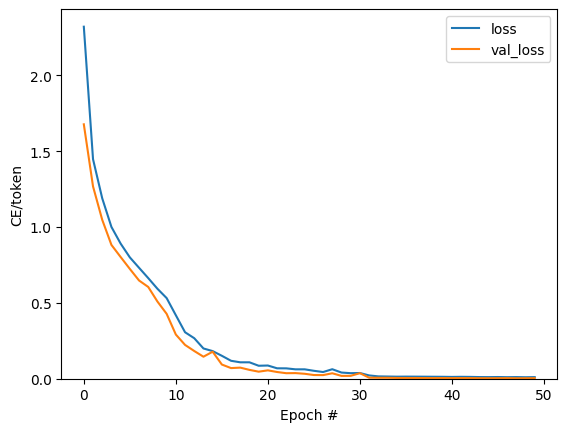

In [51]:
# Plotting training and validation loss
plt.plot(history.history['loss'], label='loss')  # Training loss over epochs
plt.plot(history.history['val_loss'], label='val_loss')  # Validation loss over epochs

# Setting y-axis limit to maintain consistency
plt.ylim([0, max(plt.ylim())])

# Labeling the axes
plt.xlabel('Epoch #')  # X-axis label indicating epoch number
plt.ylabel('CE/token')  # Y-axis label indicating cross-entropy per token

# Displaying legend for clarity
plt.legend()  # Show labels for 'loss' and 'val_loss' in the plot


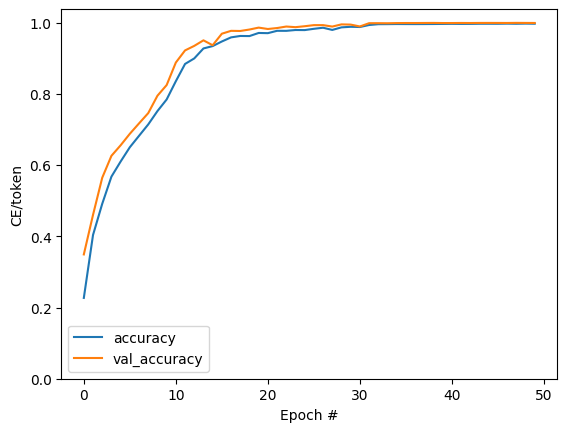

In [52]:
# Plotting training and validation accuracy
plt.plot(history.history['masked_acc'], label='accuracy')  # Training accuracy over epochs
plt.plot(history.history['val_masked_acc'], label='val_accuracy')  # Validation accuracy over epochs

# Setting y-axis limit to maintain consistency
plt.ylim([0, max(plt.ylim())])

# Labeling the axes
plt.xlabel('Epoch #')  # X-axis label indicating epoch number
plt.ylabel('CE/token')  # Y-axis label indicating cross-entropy per token

# Displaying legend for clarity
plt.legend()  # Show labels for 'accuracy' and 'val_accuracy' in the plot


### Translate

function to execute the full `text => text` translation. This code is identical to code used in encoder and decoder and also captures the attention weights.

In [53]:
# Define a method 'translate' within the 'Translator' class
@Translator.add_method
def translate(self,
              texts, *,
              max_length=100,
              temperature=0.0):
    # Process the input texts by converting them into context embeddings
    context = self.encoder.convert_input(texts)
    batch_size = tf.shape(texts)[0]  # Get the batch size from the input texts

    # Initialize empty lists to store tokens and attention weights
    tokens = []  # List to collect generated tokens
    attention_weights = []  # List to collect attention weights for each token

    # Get initial values for next_token, done, and state from the decoder
    next_token, done, state = self.decoder.get_initial_state(context)

    # Generate tokens while considering a maximum length or until termination
    for _ in range(max_length):
        # Generate the next token
        next_token, done, state = self.decoder.get_next_token(
            context, next_token, done, state, temperature)

        # Collect the generated tokens and attention weights
        tokens.append(next_token)
        attention_weights.append(self.decoder.last_attention_weights)

        # Break the loop if all sequences are done (in eager execution mode)
        if tf.executing_eagerly() and tf.reduce_all(done):
            break

    # Stack the collected lists of tokens and attention weights
    tokens = tf.concat(tokens, axis=-1)  # Concatenate tokens along the sequence axis
    self.last_attention_weights = tf.concat(attention_weights, axis=1)  # Concatenate attention weights

    # Convert the tokens back to human-readable text
    result = self.decoder.tokens_to_text(tokens)
    return result  # Return the translated text

The `translate` function works on batches, so multiple texts can be passed all at once, which is much more efficient than translating them one at a time:

### Export

To export this model, wrap `translate` method in a `tf.function`.

In [54]:
# Define a class named Export
class Export(tf.Module):
    def __init__(self, model):
        self.model = model  # Initialize the Export class with the provided model

    # Define a function 'translate' within the Export class
    @tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
    def translate(self, inputs):
        """
        Translate function signature:
        - Inputs: Tensor of strings (text inputs to be translated)
        - Returns: Translated text using the model's translate method
        """
        return self.model.translate(inputs)  # Call the model's translate method to perform translation


In [55]:
export = Export(model)

Run the `tf.function` once to compile it:

In [56]:
%%time

# Select a sample of inputs for translation
inputs = train_inputs[:5]

# Perform translation using the export module's translate function
_ = export.translate(tf.constant(inputs))

CPU times: user 1min 55s, sys: 1.77 s, total: 1min 57s
Wall time: 1min 55s


In [57]:
%%time

# Perform translation using the export module's translate function
result = export.translate(tf.constant(inputs))

# Decode and print the translated text for the first three samples
print(result[0].numpy().decode())  # Decode and print the translation of the first sample
print(result[1].numpy().decode())  # Decode and print the translation of the second sample
print(result[2].numpy().decode())  # Decode and print the translation of the third sample
print()  # Print an empty line for separation


c d c e b d a f e f b d b d a d h i a f g j a g d k                                                                          
b d b d a d d e b d a e g b d a h f h i a e j                                                                             
c e c d a d d e b d a e g b d a e i b d c f a e l b d a f m ed a g k ee a d j ef a h f h eg                                                        

CPU times: user 303 ms, sys: 26 ms, total: 329 ms
Wall time: 148 ms


Now that the function has been traced it can be exported using `saved_model.save`:

In [58]:
%%time

# Save the model using tf.saved_model.save
tf.saved_model.save(
    export,  # Exported module to be saved
    'Ayushri_Jain_934003177_Project2_Model.tf',  # Filepath to save the model
    signatures={'serving_default': export.translate}  # Define a serving signature for the model
)


CPU times: user 1min 52s, sys: 1.59 s, total: 1min 54s
Wall time: 1min 54s


In [59]:
# zip the model folder
!zip -r Ayushri_Jain_934003177_Project2_Zip_File.zip /kaggle/working/Ayushri_Jain_934003177_Project2_Model.tf

updating: kaggle/working/Ayushri_Jain_934003177_Project2_Model.tf/ (stored 0%)
updating: kaggle/working/Ayushri_Jain_934003177_Project2_Model.tf/variables/ (stored 0%)
updating: kaggle/working/Ayushri_Jain_934003177_Project2_Model.tf/variables/variables.index (deflated 70%)
updating: kaggle/working/Ayushri_Jain_934003177_Project2_Model.tf/variables/variables.data-00000-of-00001 (deflated 8%)
updating: kaggle/working/Ayushri_Jain_934003177_Project2_Model.tf/fingerprint.pb (stored 0%)
updating: kaggle/working/Ayushri_Jain_934003177_Project2_Model.tf/saved_model.pb (deflated 91%)
updating: kaggle/working/Ayushri_Jain_934003177_Project2_Model.tf/assets/ (stored 0%)


In [60]:
# download link for zip file of model
from IPython.display import FileLink
FileLink(r'Ayushri_Jain_934003177_Project2_Zip_File.zip')

/kaggle/working/Ayushri_Jain_934003177_Project2_Zip_File.zip

In [61]:
%%time
# Load the saved TensorFlow model
reloaded = tf.saved_model.load('Ayushri_Jain_934003177_Project2_Model.tf')

# Warm up the loaded model by translating inputs
_ = reloaded.translate(tf.constant(inputs))  # Warmup

CPU times: user 1min 31s, sys: 2.49 s, total: 1min 33s
Wall time: 1min 30s


In [62]:
%%time
# Translate inputs using the reloaded model and print the decoded results
result = reloaded.translate(tf.constant(inputs))

# Print the decoded translations
print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

c d c e b d a f e f b d b d a d h i a f g j a g d k                                                                          
b d b d a d d e b d a e g b d a h f h i a e j                                                                             
c e c d a d d e b d a e g b d a e i b d c f a e l b d a f m ed a g k ee a d j ef a h f h eg                                                        

CPU times: user 324 ms, sys: 47.4 ms, total: 372 ms
Wall time: 147 ms


# ACCURACY FOR TRAIN DATASET

In [64]:
import sys
correct = 0
wrong = 0
accuracy = 0
wrong_index = []
NN = len(train_inputs)
for i in range(NN//1000):
    inputs = train_inputs[i:i+1000]
    result = reloaded.translate(tf.constant(inputs))
    for j in range(1000):
        input_sentence = train_inputs[i+j]
        output_sentence = train_outputs[i+j]
        predicted_sentence = result[j].numpy().decode()
        # print(input_sentence)
        # print(output_sentence)
        # print(predicted_sentence)
        if predicted_sentence.strip() == output_sentence.strip():
            correct += 1
        else:
            wrong += 1
            wrong_index.append(i)
        message = f"Correct: {correct}, Wrong: {wrong}, Accuracy: {correct * 100 / NN:.2f}%"
        sys.stdout.write('\r' + message)
        sys.stdout.flush()
print("")
print(f"accuracy = {correct*100/NN}")

Correct: 93063, Wrong: 1937, Accuracy: 97.76%
accuracy = 97.75525210084034


In [66]:
# validation
import sys
correct = 0
wrong = 0
accuracy = 0
wrong_index = []
NN = len(val_inputs)
print(NN)
for i in range(NN//1000):
    inputs = val_inputs[i:i+1000]
    result = reloaded.translate(tf.constant(inputs))
    for j in range(1000):
        input_sentence = val_inputs[i+j]
        output_sentence = val_outputs[i+j]
        predicted_sentence = result[j].numpy().decode()
        # print(input_sentence)
        # print(output_sentence)
        # print(predicted_sentence)
        if predicted_sentence.strip() == output_sentence.strip():
            correct += 1
        else:
            wrong += 1
            wrong_index.append(i)
        message = f"Correct: {correct}, Wrong: {wrong}, Accuracy: {correct * 100 / NN:.2f}%"
        sys.stdout.write('\r' + message)
        sys.stdout.flush()
print("")
print(f"accuracy = {correct*100/NN}")

16800
Correct: 15696, Wrong: 304, Accuracy: 93.43%
accuracy = 93.42857142857143


# CELLS TO RUN FOR GETTING TEST OUTPUT

### **Please note that the model that I have built contains "translate" function which is not saved with the model if .h5 or .pb format are used. Saving as .tf type creates a directory. That's why I have zipped the directory and submitted it as my model. I have added the functionality to unzip the zip file and get the model folder below.**

## Please update the four paths according to your setup.

In [71]:
import zipfile
import os
import tensorflow as tf
import pickle

# PATH 1: where zip file is present
zip_file_path = 'Ayushri_Jain_934003177_Project2_Zip_File.zip' 

# PATH 2: where you can extract content of zip file
extract_folder = 'Ayushri_Jain_934003177_Project2_model_folder' 

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

# List the contents of the extracted folder
extracted_files = os.listdir(extract_folder)
print("Extracted files:", extracted_files)

# Load model
# PATH 3: actual model path
model_1 = tf.saved_model.load('Ayushri_Jain_934003177_Project2_model_folder/kaggle/working/Ayushri_Jain_934003177_Project2_Model.tf') 

# Load data
# PATH 4: test data path
test_input_path="/Test_input"
# test_input_path="/kaggle/input/csce636-project2/Train_input" 
test_inputs=pickle.load(open(test_input_path, 'rb'))

# Generate predicted test outputs
import sys
NN = len(test_inputs)
predicted_outputs = []
for i in range(NN):
    inputs = test_inputs[i:i+1]
    result = model_1.translate(tf.constant(inputs))
    predicted_sentence = result[0].numpy().decode()
    predicted_outputs.append(predicted_sentence)
    # print(predicted_sentence)
print(len(predicted_outputs))
pickle.dump(predicted_outputs, open('Ayushri_Jain_934003177_Project2_Prediction','wb'))

Extracted files: ['kaggle']
100


In [72]:
# download link for prediction file
from IPython.display import FileLink
FileLink(r'Ayushri_Jain_934003177_Project2_Prediction')

/kaggle/working/Ayushri_Jain_934003177_Project2_Prediction

# Cell for getting test accuracy

In [74]:
import pickle

# Loading datasets
test_output = pickle.load(open("Test_output", "rb"))
# test_output = pickle.load(open("/kaggle/input/csce636-project2/Train_output", "rb"))[:100]
test_prediction = pickle.load(open("Ayushri_Jain_934003177_Project2_Prediction", "rb"))

total_sentences = len(test_output)
total_correct_sentences = sum(pred_sentence.strip() == true_sentence.strip() for pred_sentence, true_sentence in zip(test_prediction, test_output))

test_acc = total_correct_sentences / total_sentences
your_score = round(test_acc * 1000) / 10
print(f"Your Test Accuracy: {test_acc:.4f}")
print(f"Your Score: {your_score}")

Your Test Accuracy: 0.9800
Your Score: 98.0
